In [103]:
import pandas as pd
import numpy as np
from datetime import datetime
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()
import os
import sys, urllib, json
import time
import csv

# ARIMA model
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller

In [2]:
host = '127.0.0.1'
port = 3306
db = 'soda_data_repo'
user = 'root'
password = '19940301'
# engine = create_engine(str(r"mysql+mysqldb://%s:" + '%s' + "@%s/%s") % (user, password, host, db))

conn = pymysql.connect(host=host,port=port,user=user,password=password,database = db)
cursor = conn.cursor()

In [113]:
def get_site(path='/usr/soda_data_set/predictdata/top40.txt'):
    site_list = []
    with open(path,'r') as f:
        for line in f:
            site_list.append(line.strip('\n'))
    return site_list

# need to be finished! to get the max records at these dates
def get_totalrecords():
    return None

def get_site_curve(results,daynum=100):
    list0 = []
    
    total = len(results)
    if daynum > total: 
        preserve = total
    else:
        preserve = daynum
    
    start = total-preserve
    for row in results[start:]: # throw away day 1, that is the new year day
        list0.append(row[3:]) # throw the other information
    
    site = np.array(list0)
    return site

def get_list_from_array(a):
    tem = []
    for i in a:
        tem.append(str(i))
    return tem

def add_table_title(filename = 'predict8days.csv'):
    with open(filename,'a',newline='') as f:
        writer = csv.writer(f)
        tem = ['site','date']
        res = np.array(range(0,24))
        res = get_list_from_array(res)
        tem.extend(res)
        print(tem)
        writer.writerow(tem)

def add_records(filename='predict8days.csv',site=None,days=None):
    with open(filename,'a',newline='') as f:
        writer = csv.writer(f)
        daynum = days.shape[0]
        for (i,d) in zip(range(daynum),days):
            tem = []
            tem.append(site)
            tem.append(i)
            hour_list = get_list_from_array(d)
            tem.extend(hour_list)
            writer.writerow(tem)

def add_log_title(filename='./pqfile.csv'):
    with open(filename,'a',newline='') as f:
        writer = csv.writer(f)
        tem = ['site','hour','pvalue','qvalue']
        print(tem)
        writer.writerow(tem)
        
def add_wrong_records(filename='./pqfile.csv',site=None,p=None,q=None):
    with open(filename,'a',newline='') as f:
        writer = csv.writer(f)
        renum = len(p)
        for (i,pa,qa) in zip(range(renum),p,q):
            tem = []
            tem.append(site)
            tem.append(i)
            tem.append(pa)
            tem.append(qa)
            writer.writerow(tem)

In [118]:
def armaModel(site1h):
    results = []
    plist = []
    qlist = []
    for (i,dth) in zip(range(24),site1h):
        print('day ',i)
        pd.Series(dth)
        try:
            (p,q) =(sm.tsa.arma_order_select_ic(dth,max_ar=5,max_ma=5,ic='aic')['aic_min_order'])
            arma_mod = sm.tsa.ARMA(dth,order=(p,q)).fit()
            predict = arma_mod.predict(27, 35, dynamic=True)
        except:
            if i==2:
                predict = np.zeros_like(predict)   
            print('no\n')
            p=-1
            q=-1
    
        results.append(predict)
        plist.append(p)
        qlist.append(q)
        
    results = np.array(results)
    resultst = results.T
    
    return resultst,plist,qlist   

In [116]:
table16 = 'subway16_sta_by_hour_tb'
table18 = 'subway18_sta_by_hour_tb'

sites = get_site()

save_file = './predict8days.csv'
wrong_file = './pqfile.csv'
add_table_title(save_file)
add_log_title(wrong_file)

['site', 'date', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
['site', 'hour', 'pvalue', 'qvalue']


In [119]:
for s in sites[:15]: # the top 30 is enough!
    sql = "select * from %s where site='%s' order by data ASC"%(table18,s) # select a site
    
    # get the sites table
    rnum = cursor.execute(sql1)
    results = cursor.fetchall()
    
    # get a day a sample
    site1 = get_site_curve(results,28)  # 28 days, a day contains 24h
    site1h = site1.T # 24 lines, a line contains 28 samples of a certain hour
    
    predictdays,p,q = armaModel(site1h)
    
    add_records(filename=save_file,site=s,days=predictdays) 
    add_wrong_records(filename=wrong_file,site=s,p=p,q=q)
    

day  0


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  1


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: Runti

day  2
no

day  3
no

day  4


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  5


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


no

day  6


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  7


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed

day  8


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  9


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/a

day  10


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning

day  11


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  12


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  13


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversion

day  14


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


day  15


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


no

day  16


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  17


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  18


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  19


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarni

day  20


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:632: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


day  21


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  22


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  23


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


no

day  0


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  1


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  2
no

day  3
no

day  4


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  5


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


no

day  6


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  7


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  8


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  9


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

day  10


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversion

day  11


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  12


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  13


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversion

day  14


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


day  15


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


no

day  16


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  17


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  18


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  19


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarni

day  20
day  21


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  22


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


day  23


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


no



/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [75]:
#(p,q)=(3,2)
results = []
wrong_num = []
for (i,dth) in zip(range(24),site1h):
    print(i)
    pd.Series(dth)
    try:
        (p,q) =(sm.tsa.arma_order_select_ic(dth,max_ar=5,max_ma=5,ic='aic')['aic_min_order'])
        arma_mod = sm.tsa.ARMA(dth,order=(p,q)).fit()
        predict = arma_mod.predict(27, 35, dynamic=True)
    except:
        if i==2:
            predict = np.zeros_like(predict)   
        print('no\n') 
        wrong_num.append(i)
    
    results.append(predict)

0


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

1


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or 

2
no

3
no

4


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

5


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

no

6


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./he

7


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

8


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no 

no

9


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

10


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

11


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

12


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

13


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

14


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

no

15


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

16


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

17


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

18


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

19


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

20


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

21


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

no

22


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

23


/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/tf-gpu-1.10/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: In

In [5]:
# get the sites table
rnum = cursor.execute(sql1)
results = cursor.fetchall()

# get a day a sample
site1 = get_site_curve(results,28)  # 28 days, a day contains 24h
site1h = site1.T # 24 lines, a line contains 28 samples of a certain hour

In [6]:
# ARIMA model
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller

In [7]:
# to test the series' stationarity
def test_stationarity(timeseries):
    
    #这里以7天为一个窗口，每一个时间t的值由它前面7天（包括自己）的均值代替，标准差同理。
    rolmean = timeseries.rolling(7).mean() # (timeseries,window=7)
    rolstd =timeseries.rolling(7).std() #(timeseries, window=7)
    
    #plot rolling statistics:
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    #dftest的输出前一项依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    
    print(dfoutput)

In [101]:
results = np.array(results)
resultst = results.T

In [102]:
resultst.shape

(9, 24)

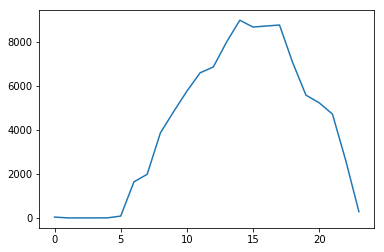

In [57]:
plt.plot(site1[20])

In [84]:
wrong_num

[2, 3, 5, 8, 14, 21]

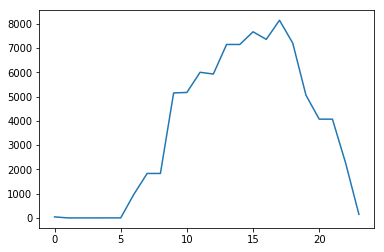

In [98]:
plt.plot(resultst[1])

#### plt.plot(results[2])

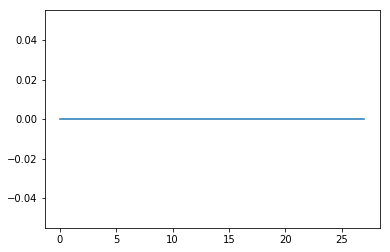

In [23]:
plt.plot(site1h[2])

In [ ]:
# 7am records in 35days
dtah7 = site1h[6]
dtah7 = pd.Series(dtah7)
# dtah7.plot(figsize=(12,8))

In [8]:
(p,q) =(sm.tsa.arma_order_select_ic(dtah7,max_ar=3,max_ma=4,ic='aic')['aic_min_order'])

NameError: name 'dtah7' is not defined

In [ ]:
test_stationarity(dtah7)

In [ ]:
print(p,q)

In [ ]:
p,d,q = (3,0,2)
arma_mod1 = sm.tsa.ARMA(dtah7,order=(p,q)).fit()#disp=-2)

In [ ]:
predict_sunspots = arma_mod1.predict(27, 35, dynamic=True)
print(predict_sunspots)

[0.03759826 0.04719318 0.05598204 0.0599445  0.0581411  0.05103951
 0.04050267 0.02929377 0.02035198]


NameError: name 'dtah7' is not defined

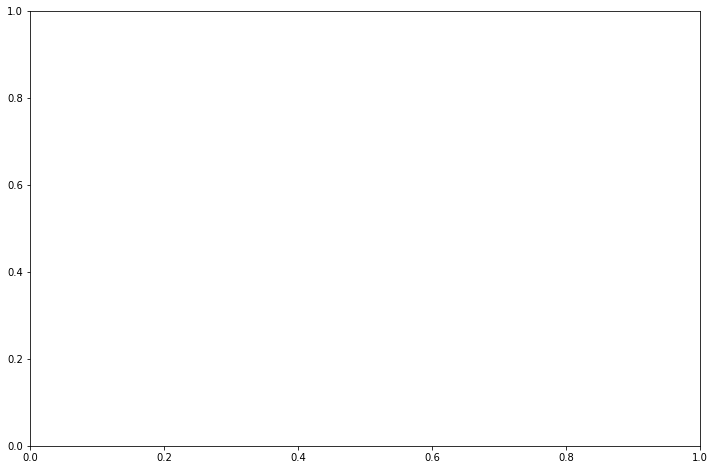

In [13]:
predict_sunspots = arma_mod.predict(27, 35, dynamic=True)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12, 8))
ax = dtah7.ix[:].plot(ax=ax)
predict_sunspots.plot(ax=ax)

In [ ]:
diff1 = dtah7.diff(1)
diff1.dropna(inplace=True)#滤除缺失数据
test_stationarity(diff1)

In [ ]:
arma_mod = sm.tsa.ARMA(diff1,(p,d,q)).fit(disp=-1,method='mle')
print(arma_mod.aic,arma_mod.bic,arma_mod.hqic)

In [ ]:
predict_sunspots = arma_mod.predict(27,35 , dynamic=True)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12, 8))
ax = dtah7.ix[:].plot(ax=ax)
predict_sunspots.plot(ax=ax)

In [ ]:
dtah7log = np.log(dtah7)

# moving_avg = dtah7log.rolling(7).mean()
# moving_std = dtah7log.rolling(7).std()
# dtah7log.plot(figsize=(12,8))
#plt.plot(dtah7log,color = 'red')
# plt.plot(moving_avg,color = 'blue')
# plt.plot(moving_std,color = 'green')


In [ ]:
# moving avg diff
log_ma_diff = dtah7log - moving_avg
log_ma_diff.dropna(inplace=True)
test_stationarity(log_ma_diff)

In [ ]:
test_stationarity(dtah7)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff1 = dtah7.diff(1)
diff1.plot(ax=ax1)

In [ ]:
sm.graphics.tsa.plot_acf(diff1)
sm.graphics.tsa.plot_pacf(diff1)

In [ ]:
arma_mod12 = sm.tsa.ARMA(dtah7,(1,0,2)).fit()
arma_mod00 = sm.tsa.ARMA(dtah7,(0,1,0)).fit()
arma_mod01 = sm.tsa.ARMA(dtah7,(0,1,1)).fit()
arma_mod10 = sm.tsa.ARMA(dtah7,(1,1,0)).fit()
arma_mod11 = sm.tsa.ARMA(dtah7,(1,1,1)).fit()

In [ ]:
print(arma_mod12.aic,arma_mod12.bic,arma_mod12.hqic)
print(arma_mod00.aic,arma_mod00.bic,arma_mod00.hqic)
print(arma_mod01.aic,arma_mod01.bic,arma_mod01.hqic)
print(arma_mod10.aic,arma_mod10.bic,arma_mod10.hqic)
print(arma_mod11.aic,arma_mod11.bic,arma_mod11.hqic)

In [ ]:
predict_sunspots = arma_mod12.predict(26,35 ,dynamic=True)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12, 8))
ax = dtah7.ix[:].plot(ax=ax)
predict_sunspots.plot(ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = dtah7log.ix[:].plot(ax=ax)
predict_sunspots.plot(ax=ax)

In [ ]:
# diff1= dta.diff(1)#我们已经知道要使用一阶差分的时间序列，之前判断差分的程序可以注释掉
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)

In [ ]:
arma_mod70 = sm.tsa.ARMA(dta,(5,3)).fit()
print(arma_mod70.aic,arma_mod70.bic,arma_mod70.hqic)

In [ ]:
predict_sunspots = arma_mod70.predict(88, 96, dynamic=True)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12, 8))
ax = dta.ix[:].plot(ax=ax)
predict_sunspots.plot(ax=ax)

In [ ]:
dta2 = []
for i in site1[80:]:
    dta2.extend(i)
    
dta2 = np.array(dta2)

In [ ]:
dta2.shape

In [ ]:
dta2 = pd.Series(dta2)

In [ ]:
dta2.plot(figsize=(12,8))

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff1 = dta2.diff(1)
diff1.plot(ax=ax1)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff2 = dta2.diff(2)
diff2.plot(ax=ax1)

In [ ]:
diff1= dta.diff(1)#我们已经知道要使用一阶差分的时间序列，之前判断差分的程序可以注释掉
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)

In [ ]:
arma_mod70 = sm.tsa.ARMA(dta2,(7,2)).fit()
print(arma_mod70.aic,arma_mod70.bic,arma_mod70.hqic)

In [ ]:
predict_sunspots = arma_mod70.predict(215,223 , dynamic=True)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12, 8))
ax = dta2.ix[:].plot(ax=ax)
predict_sunspots.plot(ax=ax)